<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/EODAngelo/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enabling GPU Acceleration

In [1]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Install Required Libraries

In [2]:
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.3 MB/s eta 0:00:00


## Import Libraries and Tools

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

## Load and Plot Assigned FITS File

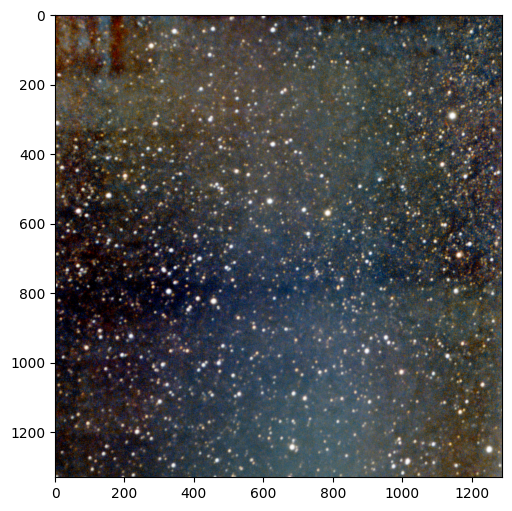

In [26]:
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/3low.fits"
response = requests.get(fits_url)
response.raise_for_status()
hdul = fits.open(BytesIO(response.content))

# Transpose to (Height, Width, 3)
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))
hdul.close()

# Manual crop values
top_margin = 400
bottom_margin = 50
left_margin = 400
right_margin = 300

# Compute cropped image
cropped_rgb = rgb_data[top_margin:rgb_data.shape[0]-bottom_margin,
                       left_margin:rgb_data.shape[1]-right_margin, :]

# Display
plt.figure(figsize=(6, 6))
plt.imshow(apply_stretch(cropped_rgb))
plt.show()


## Extract RGB Channels Seperately, Make the Number of Stars in Each Channel the Same, and Plot

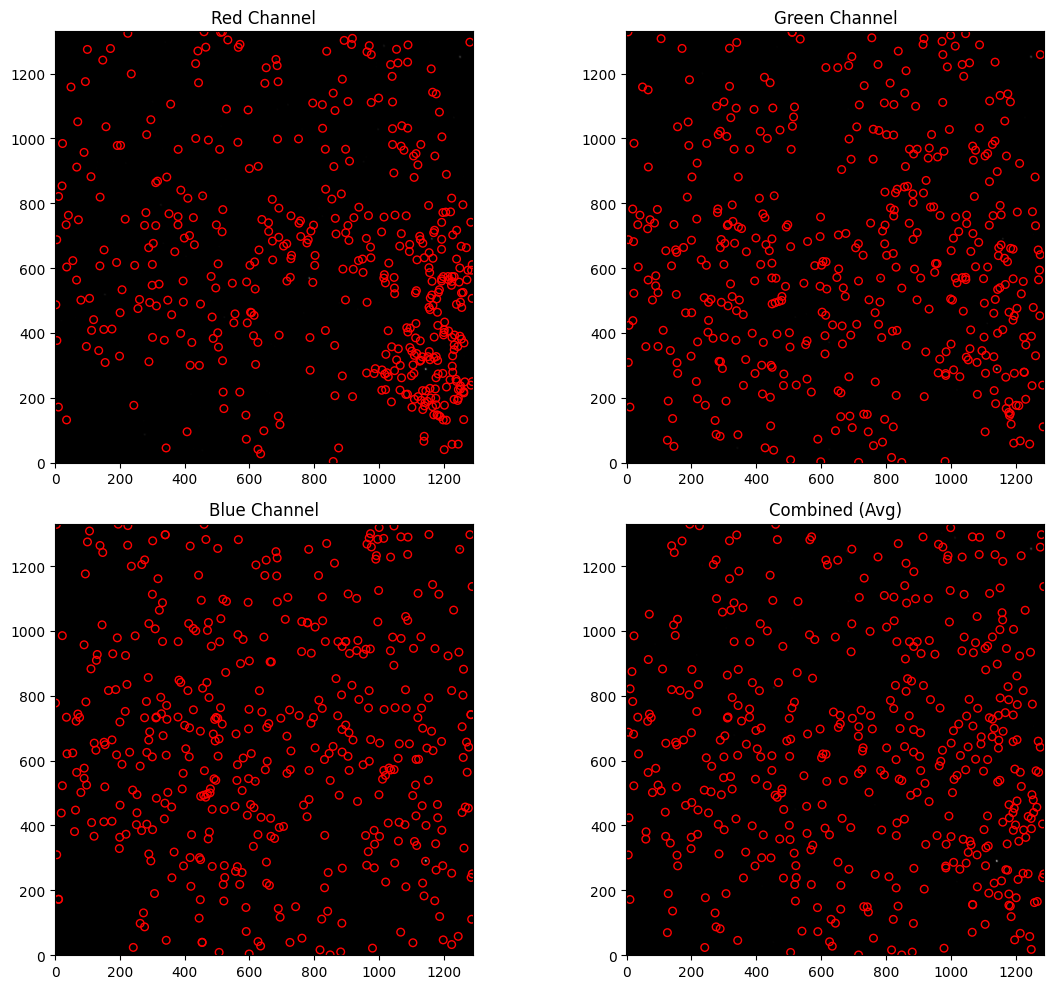

In [27]:
# Extract RGB channels separately
R = cropped_rgb[:, :, 0]
G = cropped_rgb[:, :, 1]
B = cropped_rgb[:, :, 2]

# Star detection function
def detect_stars(channel_data, threshold_scale=5.0):
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=threshold_scale * std)
    return finder(channel_data - median)

# Detect stars in each channel
r_sources = detect_stars(R)
g_sources = detect_stars(G)
b_sources = detect_stars(B)

# Equalize number of detected stars across channels
def sample_sources(sources, target_n):
    if sources is None or len(sources) <= target_n:
        return sources
    return sources[np.random.choice(len(sources), target_n, replace=False)]

min_count = min(len(r_sources), len(g_sources), len(b_sources))
r_sources = sample_sources(r_sources, min_count)
g_sources = sample_sources(g_sources, min_count)
b_sources = sample_sources(b_sources, min_count)

# Create average image
avg_channel = np.mean(cropped_rgb, axis=2)
avg_sources = detect_stars(avg_channel)
avg_sources = sample_sources(avg_sources, min_count)

# Plot all channels + average with detected stars
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
titles = ['Red Channel', 'Green Channel', 'Blue Channel', 'Combined (Avg)']
channels = [R, G, B, avg_channel]
sources_list = [r_sources, g_sources, b_sources, avg_sources]

for ax, img, sources, title in zip(axs.flat, channels, sources_list, titles):
    ax.imshow(img, cmap='gray', origin='lower')
    if sources is not None:
        ax.scatter(sources['xcentroid'], sources['ycentroid'], s=30,
                   edgecolor='r', facecolors='none')
    ax.set_title(title)

plt.tight_layout()
plt.show()

## Calculate Color and Normalized Flux Ratios / Generate New Features Variable

In [31]:
# Extract flux and sharpness from green channel
flux = g_sources['flux']
size = g_sources['sharpness']

# Also extract red and blue flux
flux_r = r_sources['flux']
flux_b = b_sources['flux']

# Apply a valid data mask
valid_mask = (flux > 0) & (size > 0) & (flux_r > 0) & (flux_b > 0)
flux = flux[valid_mask]
size = size[valid_mask]
flux_r = flux_r[valid_mask]
flux_b = flux_b[valid_mask]

# Normalize brightness and size
flux_norm = (flux - np.min(flux)) / np.ptp(flux)
size_norm = (size - np.min(size)) / np.ptp(size)

# Compute color ratios (R/G and B/G)
ratio_rg = flux_r / flux
ratio_bg = flux_b / flux

# Apply log1p to stretch small ratios
ratio_rg_log = np.log1p(ratio_rg)
ratio_bg_log = np.log1p(ratio_bg)

# Normalize color ratios
ratio_rg_norm = (ratio_rg_log - np.min(ratio_rg_log)) / np.ptp(ratio_rg_log)
ratio_bg_norm = (ratio_bg_log - np.min(ratio_bg_log)) / np.ptp(ratio_bg_log)

# Combine into final features array
features = np.vstack([flux_norm, size_norm, ratio_rg_norm, ratio_bg_norm]).T

## Adapt Input and Output Shape to New Feature Using GPU

Using device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


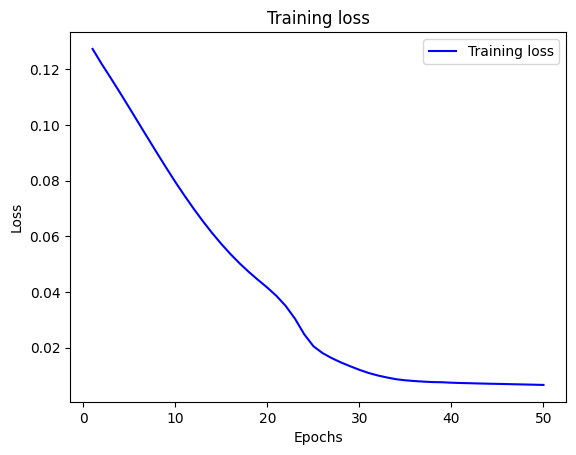

In [29]:
# Print device info to confirm GPU use
print("Using device:", tf.config.list_physical_devices('GPU'))

# Define autoencoder model with input/output size = 4
input_layer = Input(shape=(4,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(2, activation='relu')(encoded)  # Bottleneck

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(4, activation='sigmoid')(decoded)  # Output must match input size

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder (on GPU if available)
history = autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=0)

loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Generate New Plots from the New Clustering

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


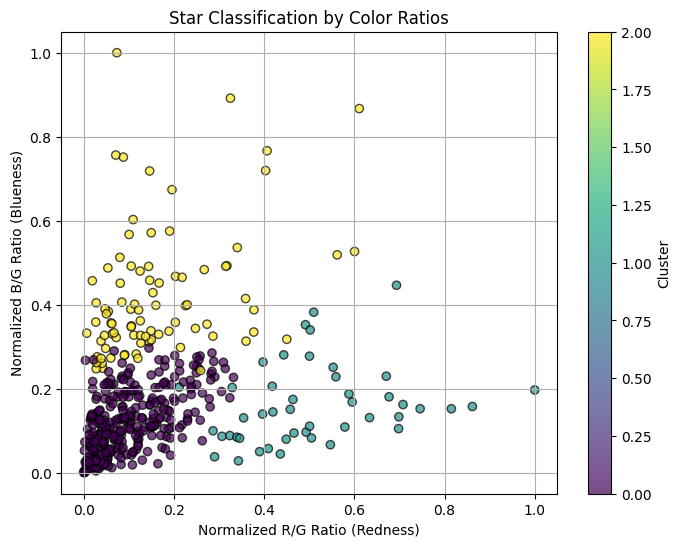

In [32]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=2).output)
compressed_features = encoder.predict(features)

# Cluster
kmeans = KMeans(n_clusters=3, random_state=0)
predicted_labels = kmeans.fit_predict(compressed_features)

# Pull color ratios from features (columns 2 and 3)
ratio_rg_norm = features[:, 2]
ratio_bg_norm = features[:, 3]

# Plot: Color Ratios (R/G vs B/G) colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(ratio_rg_norm, ratio_bg_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio (Redness)')
plt.ylabel('Normalized B/G Ratio (Blueness)')
plt.title('Star Classification by Color Ratios')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()